# CSCI E-25           
## Working with Image Data         
Andrew Caide      

---

## Introduction   

This lesson will familarize you with the basic concepts of working with image data and some statistical properties of images. Some key points are of this lesson are:     
1. Discrete pixel structure of digital images.    
2. Representation of color and gray scale images.   
3. Intensity distribution of image data.
4. Equalizing intensity distributions and improving contrast. 
5. Resizing images. 

## Loading Data

To get started with this lesson, execute the code in the cell below to import the packages you will need. 

In [1]:
import skimage 
from skimage import data
from skimage.filters.rank import equalize, threshold
import skimage.filters as skfilters
from skimage import exposure
from skimage.morphology import disk, square
from skimage.color import rgb2gray
from skimage.measure import block_reduce
from skimage.transform import resize
import numpy as np
import numpy.random as nr
from PIL import Image
from scipy import signal
from sklearn.preprocessing import MinMaxScaler 
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Structure of a Color Image Object

The code in the cell below loads a color image of a human retina, prints the data types and dimensions of the image object, and displays the image. The image is displayed by [matplotlib.pyplot.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html). Execute the code and examine the result.

The image object is <class 'numpy.ndarray'>
The pixel values are of type <class 'numpy.uint8'>
Shape of image object = (1411, 1411, 3)


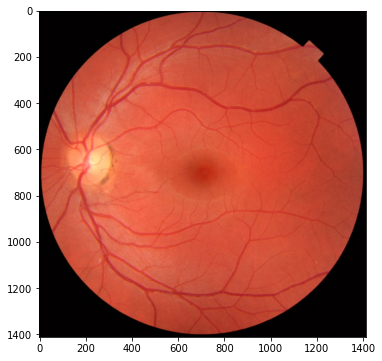

In [2]:
retina_image = data.retina()
print('The image object is ' + str(type(retina_image)))
print('The pixel values are of type ' + str(type(retina_image[0,0,0])))
print('Shape of image object = ' + str(retina_image.shape))
fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(retina_image)

The image object has 3-dimensions, the two spatial dimensions and the 3 color channels. Examine this image noticing the wide variation in color and intensity. Notice also that the illumination of the retina does not appear uniform, resulting in a bright spot on the left and a darker region on the right.  

> **Exercise 1-1:** Complete the function in the cell below to display the 3 color channels of the image and the original image in a 2x2 array using the [matplotlib.pyplot.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function. The color channels are in red, green, blue order and should be displayed as gray scale using the `cmap=plt.get_cmap('gray')` argument. Your function should label the channels and the original image. Execute your function and examine the results.    

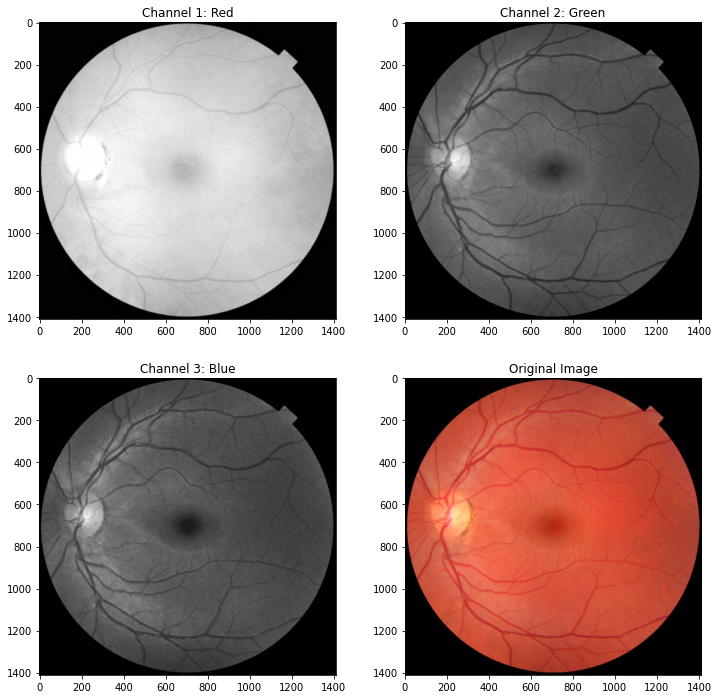

In [3]:
def plot_3_color_channels(img,plot_size=12):
    '''Function plots the three color channels of the image along with the complete image'''
    fig, ax = plt.subplots(2,2, figsize=(plot_size, plot_size))
    ax = ax.flatten()
    ## Put you code below
    cmap=plt.get_cmap('gray') 
    ax[0].imshow(img[:, :, 0],cmap=plt.get_cmap('gray'))
    ax[0].set_title('Channel 1: Red')
    ax[1].imshow(img[:, :, 1],cmap=plt.get_cmap('gray'))
    ax[1].set_title('Channel 2: Green')
    ax[2].imshow(img[:, :, 2],cmap=plt.get_cmap('gray'))
    ax[2].set_title('Channel 3: Blue')
    ax[3].imshow(img)
    ax[3].set_title('Original Image')
    #_=ax[0].imshow(grey)
    
    
plot_3_color_channels(retina_image)    

> Examine the intensity (brightness) of the color channels and answer these questions:    
> 1. Which channel has the greatest intensity, and does this make sense given the image?      
> 2. Is it likely that the saturation of the red channel arises as an artifact of the illumination spot on the left of the retina image?      
> **End of exercise.**



> **Answers:**   
> 1. The **red channel** has the greatest intensity, and this makes sense given the image is nearly entirely red. 
> 2. No; unless the light emitted from the bright illumination is red, this is unlikely. Furhermore the illumination persists throughout all channels, as does the dark spot. If the saturation was an artifact of the illumination, all channels would be saturated.

When working with digital images it is always important to keep in mind the discrete nature of the samples. To demonstrate the discrete nature of a digital image you can visualize a 100 pixel, or $10 \times 10$, sample from the larger image by executing the code in the cell below. 

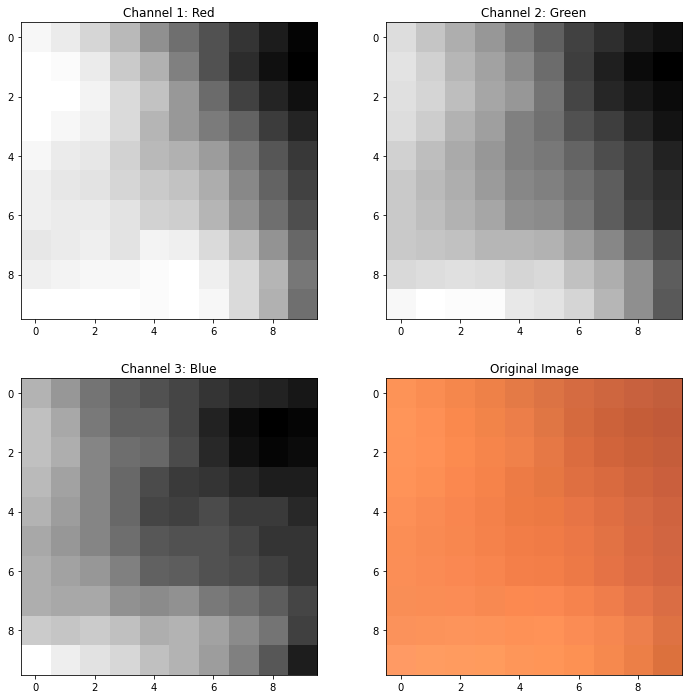

In [4]:
plot_3_color_channels(retina_image[600:610,300:310,:])

Notice the discrete nature in each of the three color channels and the color image.

## Statistical Properties of an Image  

The next question is, what is the distribution of pixel intensities in the 3 color channels of the image? Histograms and cumulative density functions are used to analyze these distributions. The code in the cell below plots the histograms of the 3 color channels along with their cumulative distributions. Execute this code and examine the results.    

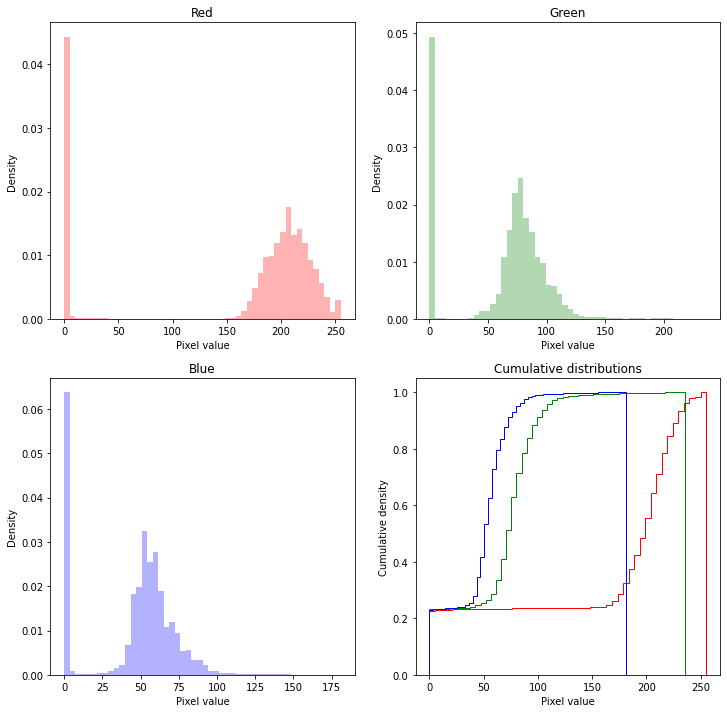

In [5]:
def plot_image_distributions(img):
    '''Function plots histograms of the three color channels of the image along 
    with the cumulative distributions'''
    fig, ax = plt.subplots(2,2, figsize=(12, 12))
    ax = ax.flatten()
    titles=['Red','Green','Blue']
    for i in range(3):
        ax[i].hist(img[:,:,i].flatten(), bins=50, density=True, color=titles[i], alpha=0.3)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel('Pixel value')
        ax[i].set_ylabel('Density')
        ax[3].hist(img[:,:,i].flatten(), bins=50, density=True, cumulative=True, color=titles[i], histtype='step')
    ax[3].set_title('Cumulative distributions')  
    ax[3].set_xlabel('Pixel value')
    ax[3].set_ylabel('Cumulative density')  
    
plot_image_distributions(retina_image)    

There are several properties of the distribution of the pixel values which are important:     
1. The distribution of the intensity for of the red channel has clearly higher values than the other channels.    
2. A significant fraction of pixel values have 0 intensity for all 3 color channels. These pixels are primarily black background around the retina, but may also represent the dark pupil spot in the center of the retina.   
3. A few red channel pixels have the maximum value of 255. The red intensity of these pixels is said to be saturated.      

----

## Intensity Equalization    

Our next question to address is what is the ideal distribution of the intensity values of an image? A useful, and obviously answer, is that we want the pixel values over the full range of possible values. For unsigned integer values, {0,255}. Further, the distribution of pixel values should be uniform. For the $n=256$ unsigned integer values the **probability mass function**, or **PMF**, of the $ith$ value is:     

$$p(i) = \frac{1}{n}$$      

And the **cumulative density function**, or **CDF**, of the uniform distribution at the $ith$ value is:   

$$CDF(i) = \sum_0^i \frac{1}{n}$$  

We can visualize an example of a gray-scale image of unsigned integers on the range {0,255} with random uniform distributed pixel values. The code in the cell below forms a gray-scale image randomly sampled uniform distributed pixel values and displays the result.               

(1411, 1411)


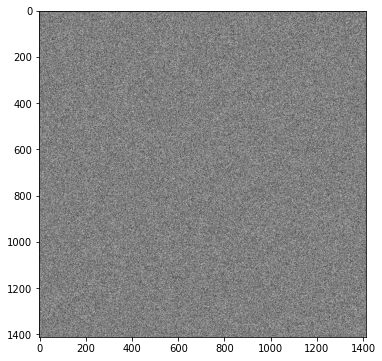

In [6]:
random_image = np.multiply((nr.uniform(low=0.0, high=255.0, size=retina_image.shape[0]*retina_image.shape[1])), 255).reshape((retina_image.shape[0], retina_image.shape[1]))
random_image = random_image.astype(np.uint8)
print(random_image.shape)
fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(random_image, cmap=plt.get_cmap('gray'))

To view the distribution of the pixel values of this image execute the code in the cell below. 

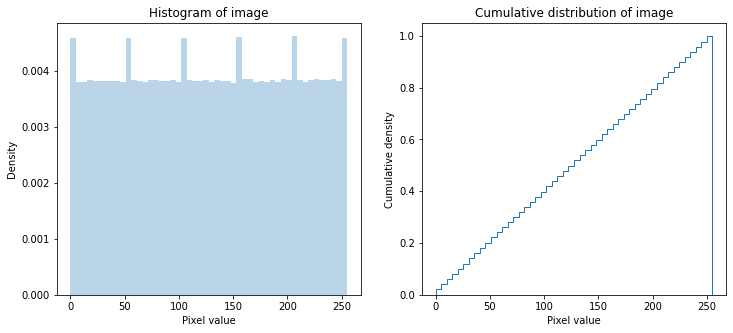

In [7]:
def plot_gray_scale_distribution(img):
    '''Function plots histograms a gray scale image along 
    with the cumulative distribution'''
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].hist(img.flatten(), bins=50, density=True, alpha=0.3)
    ax[0].set_title('Histogram of image')
    ax[0].set_xlabel('Pixel value')
    ax[0].set_ylabel('Density')
    ax[1].hist(img.flatten(), bins=50, density=True, cumulative=True, histtype='step')
    ax[1].set_title('Cumulative distribution of image')  
    ax[1].set_xlabel('Pixel value')
    ax[1].set_ylabel('Cumulative density') 
    plt.show()

plot_gray_scale_distribution(random_image)    

> **Exercise 1-2:** To compare the pixel value distribution of the retina image to the ideal values do the following:   
> 1. Create a gray-scale image object named `retina_gray_scale` using the [skimage.color.rgb2gray](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html) function. 
> 2. Print the dimensions of the image object.  
> 3. Display the gray-scale image. Make sure the image is large enough to see the details.   
> 4. Plot the distribution of the pixel values of the gray-scale image. 

Dimensions of 'retina_gray_scale': (1411, 1411)


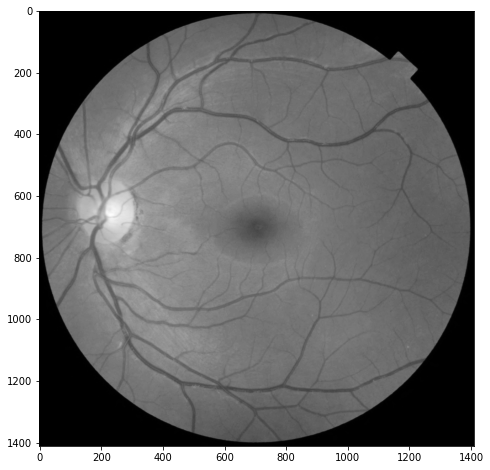

In [8]:
def plot_grayscale(img):
    fig, ax = plt.subplots( figsize=(8, 8))
    _=ax.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

## Put you code below    
retina_gray_scale=rgb2gray(retina_image)
print("Dimensions of 'retina_gray_scale': {}".format(retina_gray_scale.shape))
plot_grayscale(retina_gray_scale)

Histogram of original image:


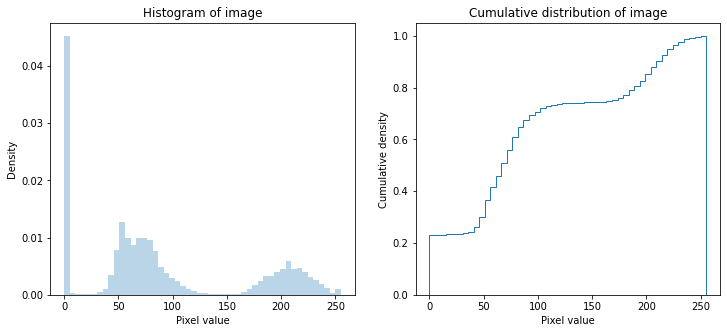

Histogram of gray-scaled image:


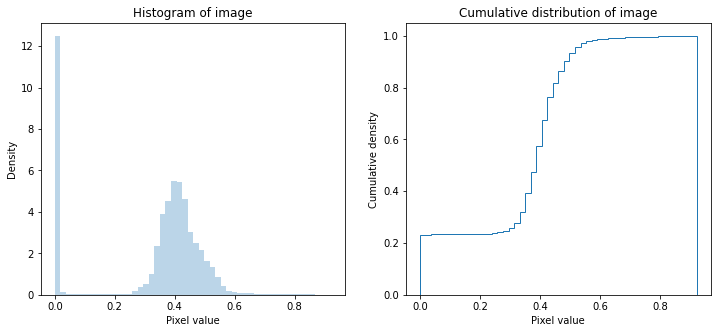

In [9]:
print("Histogram of original image:")
plot_gray_scale_distribution(retina_image)

print("Histogram of gray-scaled image:")
plot_gray_scale_distribution(retina_gray_scale)

> Examine the distribution plots. How would you describe these results with respect to the ideal distribution? How do you think the range of pixel values limit the contrast of the image?     
> **End of exercise.**

> **Answer:**  
The histogram of the original image matches what a plot of the three histograms of the individual RGB channels would look like in one plot: peaks around 50, 75, and 220. This histogram looks bimodal but there are three peaks.
The grayscale more closely matches an ideal gaussian with a single peak.    
> As defined in Section 1-3: "Contrast of an image is range between the minimum and maximum pixel values of an image". Having a wider range of pixel values increases contrast, but can also increase risk of noise (see the pixel value gaussian for noise above).

#### End of 1-2
----

**Contrast** of an image is range between the minimum and maximum pixel values of an image. The larger the range of values the more distinctive the differences in the image will be. To improve the contrast in an image we need to **equalize** the pixel values over the maximum of the range. The goal is to find a transformation that stretches the pixel values into a uniform distribution. This process is know as **histogram equalization**.      

Histogram equalization can be performed in a number of ways. The obvious algorithm is global histogram equalization. The pixel values are transformed to equalize the histogram across the entire image. However, if illumination is inconsistent across the image, global equalization will not be optimal. An alternative is to perform local histogram equalization over small areas of the image. This method is known as **adaptive histogram equalization**. Adaptive equalization can compensate for uneven illumination across the image.           

> **Exercise 1-3:** You will now apply both common types of histogram equalization to the gray-scale retina image. Use both the [sklearn.exposure.equalize_hist](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html) function and the [sklearn.exposure.equalize_adapthist](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist) function. Create and execute a function which does the following:    
> 1. Executes the equalization function passed as an argument. Pass the function name as a string using the Python [eval](https://www.w3schools.com/python/ref_func_eval.asp) function.  
> 2. Display the equalized gray-scale image using the `plot_grayscale()` function.   
> 3. Plot the distribution of the pixel values of the equalized gray-scale image using the `plot_gray_scale_distribution()` function.    
> 
> Execute your function for the two equalization algorithms. You can do this by iterating over a list of the function names. Print a line indicating which function is being executed. Save the results in a Numpy object named `retina_gray_scale_equalized`. 

Testing equalization function: exposure.equalize_hist on the grey-scaled image


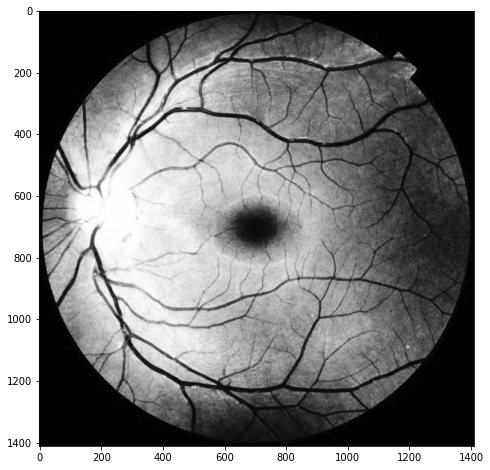

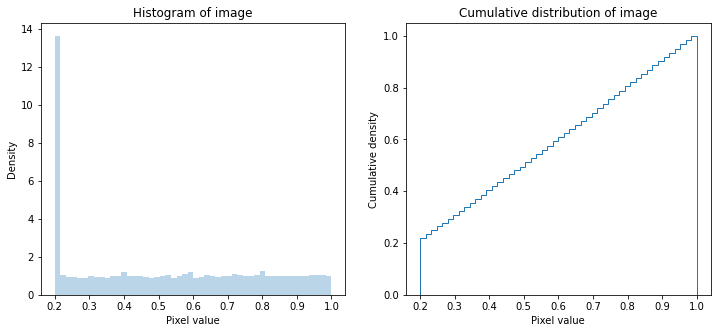

Testing equalization function: exposure.equalize_adapthist on the grey-scaled image


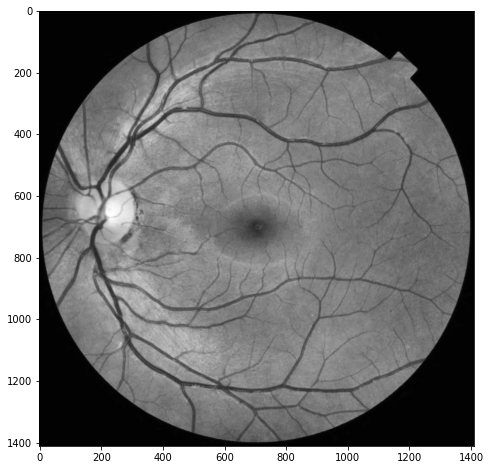

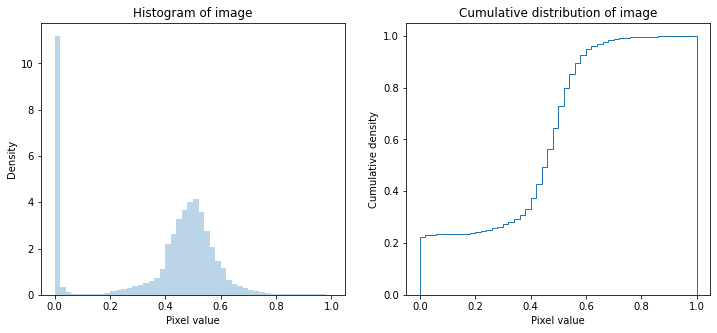

In [35]:
def test_equalize(img, func): 
    img_equalized = np.multiply(eval(func)(img), 255).astype(np.uint8)
    plot_grayscale(np.divide(img_equalized, 255.0))
    plot_gray_scale_distribution(np.divide(img_equalized, 255.0))    
    return img_equalized

## Put you code below
funcs=['exposure.equalize_hist', 'exposure.equalize_adapthist']
gray_scale_retina_dic={}
for function in funcs:
    print("Testing equalization function: {} on the grey-scaled image".format(function))
    # Saving
    gray_scale_retina_dic[function]=test_equalize(retina_gray_scale,function)

> Answer the following questions:  
> 1. Compare the unequalized and equalized images. What aspects of the of the images are more apparent with the improved contrasted.  
> 2. Compare the distributions of pixel values between the unequalized image, the random uniformly distributed image, and equalized images (2). Which of these histograms look the most similar and what does this tell you about the contrast of the image. 
> 3. Does the difference in the distribution between the locally equalized image and the globally equalized image make sense and why?   
> **End of exercise.**

> **Answers:**   
> 1. The histogram equalization method uniformly equalizes the contrast across the image. This means all shadows are now as dark as the darkest shadows, which can be misleading if we're trying to determine depth or true color. Adaptive equalization, `equalize_adapthist()`, however applies histogram equalization over different tiles of the image, preventing uniformly matching and equalizing dark spots. By locally equalizing an image, over/under exposure is contained and does not influence the remainder of the image. For instance, dark spots around the bright spot to the left of the image is very visible in the adaptive image.   
> 2. A. The grey-scale and adaptive equalization histograms closely resemble one another. The uniformly equalized image has the same histogram fingerprint as static noise, which is exactly what the `equalize_hist()` function aims to do.    
     B. The adaptive-equalization histogram closely resembles the greyscaled image; the original image either has good contrast, or was taken with a camera that performs adaptive contrast adjustment.
> 3. The globally equalized image does not make sense; the original image has an over-exposed spot (the bright light) which will skew the pixel value distribution in favor of the bright spot (all high pixel values will be attributed to this spot). This leaves the remainder of the image suboptimal pixel values to work with. Local equalization overcomes this problem by focusing the equalization in kernals/regions in the image, preventing over/under exposed areas of the photo from influencing the contrast everywhere else. 

#### End of 1-3
---

> **Exercise 1-4:** Equalization of multi-channel images, including color images, adds complications. As you have already seen, the distribution of pixel values for each of the channels is likely to be quite different. Therefore, each channel must be equalized independently.  You will now perform this operation on the color retina image.    
> The equalization is done by iterating over the color channels. Use the [sklearn.exposure.equalize_adapthist](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist) function.  
> Finally, display the images for each of the color channels and the complete image using your `plot_3_color_channels()` function and the `plot_image_distributions()` function.  

Original Image:


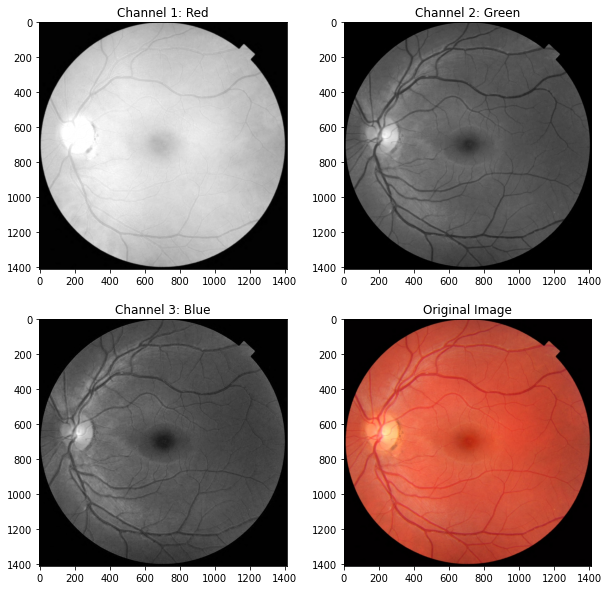

In [11]:
print("Original Image:")
plot_3_color_channels(retina_image,plot_size=10)  

Equalized Image:


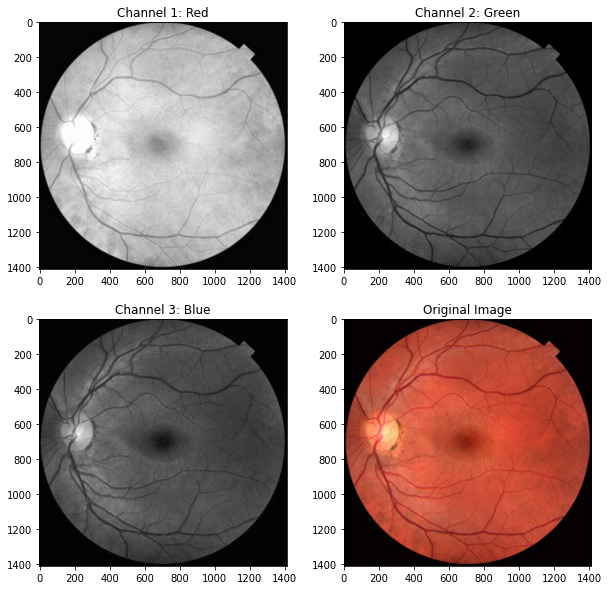

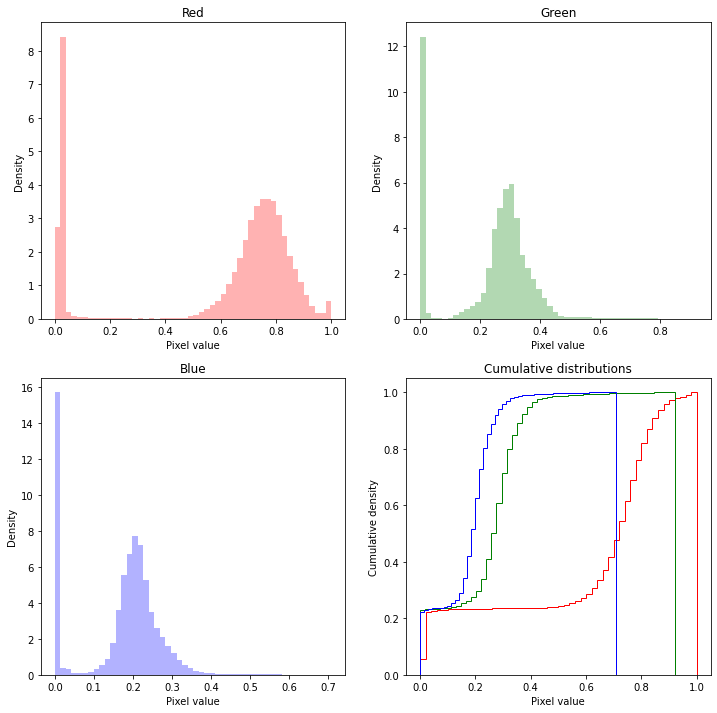

In [12]:
## Put you code below
print("Equalized Image:")
equalized_retina_image = exposure.equalize_adapthist(retina_image)
plot_3_color_channels(equalized_retina_image,plot_size=10)
plot_image_distributions(equalized_retina_image) 

> Examine these results and answer the answer the following questions:      
> 1. Did the histogram equalization achieve the goal of improving the contrast of the image both in the color channels and for the 3-channel color image, and why?   
> 2. Given the use of the locally adapted histogram equalization algorithm, does the distribution of the pixel values in the 3 channels of the equalized image make sense, and why?    
> 3. What is the evidence of saturation of the red color channel after equalization?    
> 4. Does the change in color of the 3-channel color image make sense given the histogram equalization, and why?    
> **End of exercise.**

> **Answers:**
> 1.    Yes, adaptive equalization reveals more detail than the original retina image. There is more noticeable vascularity (veins) and cloudiness observed in the retina. 
> 2.    Adaptive equalization will not greatly disturb the pixel value distribution in the way global equalization would. Furthermore channels are equalized indepently; the pixel value of the red channel will not influence the distribution of pixel values in the green/blue channels. Also, depending on the contrast quality of the image, there could exist a possibility that adaptive equalization may do very little to nothing at all. 
> 3.    The extremely high distribution of pixel values in the red channel compared to the green/blue channel suggests saturation in the red color channel. This is evident in the composite image by how red/orange the entire image is. 
> 4.    Aaptive equalization in the blue and green channels lowered the overall contributions of these channels, leading to an overall darker image more heavily influenced by the red channel. The changes to the histogram aren't severe/very noticeable, but there are pixel more pixel values between 0-0.1 than in their counterparts (0-25 for blue, 0-50 for green).

Contrast improvement is such an important data preparation step for computer vision that many algorithms have been proposed. One approach is to use rank statistics over a small region or local region of the image. The [skimage.filters.rank.equalize](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize) function implements just such an algorithm. Execute the code in the cell below to see the effect this algorithm has on the gray-scale retina image. |

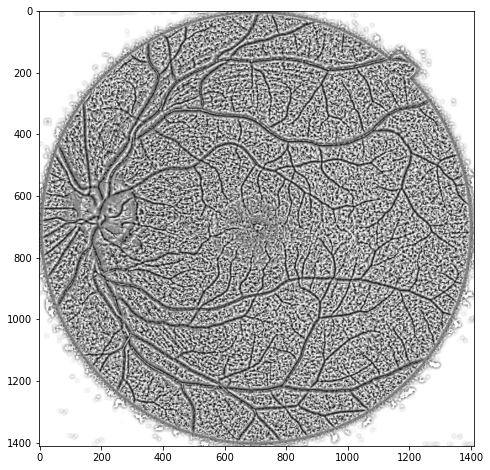

In [13]:
retina_local_equalized = equalize(np.multiply(retina_gray_scale, 255).astype(np.uint8), selem=disk(9))
plot_grayscale(retina_local_equalized)

This locally equalized image shows considerably more detail than the global histogram equalization or adaptive histogram equalization methods. But, is this what we really want? In some cases yes. If fine details like texture are important to the computer vision solution, this equalization would be preferred. However, too much detail might lead to unnecessary complexity if the goal was to identify major structural elements of the image. In summary, the correct preprocessing for an image depends on the other algorithms one intends to apply. } 

#### End 1-4.
----

## Binary Images  

Many computer vision algorithms operate on binary images. Primarily these methods are in the category of **morphology**, which we will explore later. A binary image has only two values, $\{positive, negative \}$ or $\{ 1, 0 \}$.   

> **Exercise 1-5:** You will create a function named `transform2binry()` to convert either a 3-channel color image or gray scale image to a integer binary image, $\{ 1, 0 \}$, given a threshold value in the range $0 \le threshold \le 1$ as an argument. The function must do the following:   

1. If the image is multi-channel, convert it to gray-scale.

2. Transform the threshold value to the fraction of the range of the pixel values. Print the transformed threshold value.

3. Apply the threshold to the gray-scale pixel values and return the binary images.

4. Execute your function on the **globally equalized *color* retina image**, print the dimensions of the binary image, and display the image, using a threshold value of 0.37.

5. Execute your function on the **globally equalized gray-scale** retina image, print the dimensions of the binary image, and display the image, using a threshold value of 0.37.

6. Execute your function on the **locally equalized gray scale** retina image, print the dimensions of the binary image, and display the image, using a threshold value of 0.37.

In [14]:
## Put you code below
def transform2binary(original_image, threshold):
    img=original_image.copy()
    if len(img.shape)==3:
        print("Grayscaling the image")
        img=rgb2gray(img)
    img_thresh=img.max()*threshold
    
    print("***\nMax pixel value: {:.2f}\n\
Original Threshold: {}\n\
Transformed threshold value: {:.2f}".format(img.max(),threshold,img_thresh))
    # Apply Threshold
    img[img<=img_thresh]=0
    img[img> img_thresh]=1
    return(img)

Testing globally equalized color image:


C:\Users\andre\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


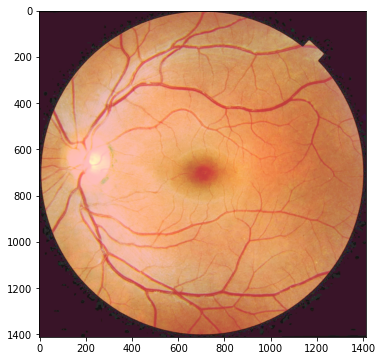

In [15]:
print("Testing globally equalized color image:")
img_equalized = np.multiply(eval('exposure.equalize_hist')(retina_image), 255).astype(np.uint8)
fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(img_equalized)

Working on the *Globally equalized retina* image
Grayscaling the image
***
Max pixel value: 0.97
Original Threshold: 0.37
Transformed threshold value: 0.36
Binary image shape: (1411, 1411)


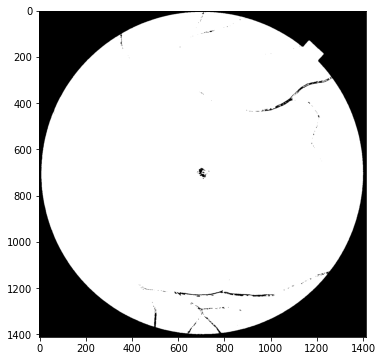

In [16]:
print("Working on the *Globally equalized retina* image".format(funcs[1]))
binary_img=transform2binary(img_equalized,threshold=0.37)
print("Binary image shape: {}".format(binary_img.shape))

fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(binary_img, cmap=plt.get_cmap('gray'))

Working on the globally equalized gray-scale image with _exposure.equalize_hist()_ applied
***
Max pixel value: 255.00
Original Threshold: 0.37
Transformed threshold value: 94.35
Binary image shape: (1411, 1411)


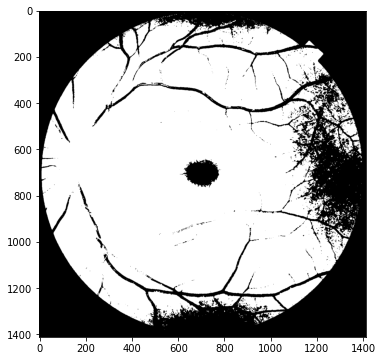

In [17]:
print("Working on the globally equalized gray-scale image with _{}()_ applied".format(funcs[0]))
binary_img=transform2binary(gray_scale_retina_dic['exposure.equalize_hist'],threshold=0.37)
print("Binary image shape: {}".format(binary_img.shape))

fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(binary_img, cmap=plt.get_cmap('gray'))

Working on the grayscale image with _exposure.equalize_adapthist()_ applied
***
Max pixel value: 255.00
Original Threshold: 0.37
Transformed threshold value: 94.35
Binary image shape: (1411, 1411)


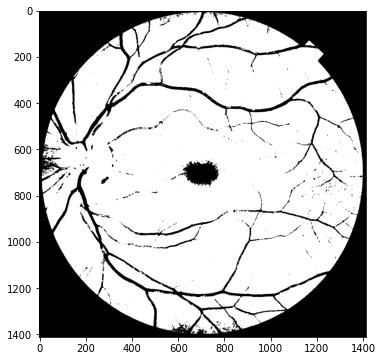

In [33]:
print("Working on the grayscale image with _{}()_ applied".format(funcs[1]))
binary_img=transform2binary(gray_scale_retina_dic['exposure.equalize_adapthist'],threshold=0.37)
print("Binary image shape: {}".format(binary_img.shape))

fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(binary_img, cmap=plt.get_cmap('gray'))

> Examine the image and answer the following questions.  
> 1. Does the binary image created from the unequalized color image capture key aspects of the retina and why?     
> 2. Compare the binary images created from the equalized color image and the equalized gray scale image. Is there any difference, and is this the result you would expect?  
> **End of exercise.**      

> **Answers:**
> 1.    **NOTE:** According to the forum I understood we were looking for the **equalized** color image. With that said, the pixel value histograms for all three chanels are uniform; when applying a grayscale a tremendous amount of information about the contrast is completely lost. This problem is further exaserbated when defining ranges for the binary image because image detail (constrast, pixel values/color) is not present.  
> 2.    The globally equalized gray scale image is very messy, and this is expected; global equalization means certain pixel values were forced out of their normal or best fitted range; the pixel value histogram shows an equal distribution across 0-1. On the other hand, the pixel values for the adaptive histogram filter is closer to what the true image should be. The pixel value histogram suggests a peak at about 0.4 to 0.41 so a fit of 0.37 might not be perfect.

#### End of 1-5
----

In the foregoing exercise, the threshold for the decision classifying pixel values as true or false, $\{ 0, 1 \}$ was set manually by trial and error. There are numerous algorithms which have been devised for finding thresholds. In general, these algorithms attempt to find an optimal threshold using various measures. Ideally, these algorithms search for a low frequency point in the pixel value histograms which can be used to divide the values.     

**Exercise 1-6:** We can create a binary image using one of the many established algorithms to compute a threshold. In this case [Otsu's threshold algorithm](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=threshold_otsu#skimage.filters.threshold_otsu). Use this function to find a threshold, apply the threshold to the the equalized gray-scale image to compute a binary image, and plot the result.       

Otsu's Threshold: 66
Otsu's Threshold: 66


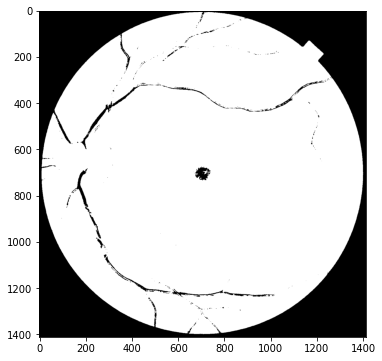

In [36]:
## Put you code below
equalized_grayscale = gray_scale_retina_dic['exposure.equalize_adapthist'].copy()
otsu_threshold = skfilters.threshold_otsu(equalized_grayscale)
print("Otsu's Threshold: {}".format(otsu_threshold))
binary = equalized_grayscale >= otsu_threshold
print("Otsu's Threshold: {}".format(otsu_threshold))

fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(binary, cmap=plt.get_cmap('gray'))

> How does this binary image compare the to ones computed with the threshold found by trail-and-error, and why?       
> **End of exercise.**

> **Answer:** The mean pixel value is around 40 according to the histograms. Otsu's Threshold seems to overshoot significantly, washing away a lot of the details under the 40 pixel band. It doesn't look like a significant provement because of how much detail has been lost by selecting a threshold that exceeds the mean pixel value.

#### End of 1-6
----

## Inversion of Images  

For some machine vision algorithms it is easier or more effective to work with the **inverse image** or **negative** of the image. The concept is simple. Pixel values are generally restricted to a range like $\{ 0 - 255 \}$ for unsigned integer representation or $\{ 0.0 - 1.0 \}$ for a floating point image. The given an intensity $P_{i,j}$ of the $ij$th pixel, the inverted intensity, $I_{i,j}$, is then:

$$I_{i,j} = max\big[ P \big] - P_{i,j}$$

Where, $max\big[ P \big]$ is the largest value the representation of the image allows, typically 255 or 1.0. 

> **Exercise 1-7:** You will now write a function named `invert_image` that will perform image inversion on both 3-channel and gray-scale images. Make sure you find the correct maximum value for the data type of the image.     
> 
> Now, apply your function to the original color retina image and display the image along with the distribution plot.   

In [20]:
equalized_retina_image.copy().shape

(1411, 1411, 3)

In [21]:
## Put you code below

def invert_image(img):
    res=img.copy()
    if len(img.shape)==3:
        print("Working with a 3-channeled image.")
        for i in range(res.shape[2]):
            channel_max=res[:,:,i].max()
            res[:,:,i]=np.array(channel_max-res[:,:,i])           
        return(res)
    else:
        img_max=res.max()
        res=img_max-res
        return(res)

inverted_retina_image=equalized_retina_image.copy()
inverted_retina_image=invert_image(inverted_retina_image)

Working with a 3-channeled image.


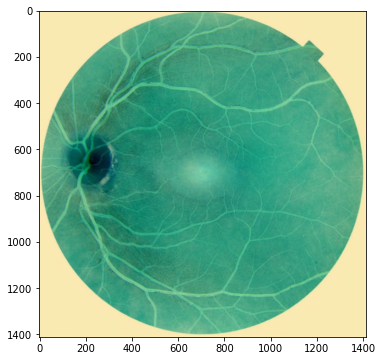

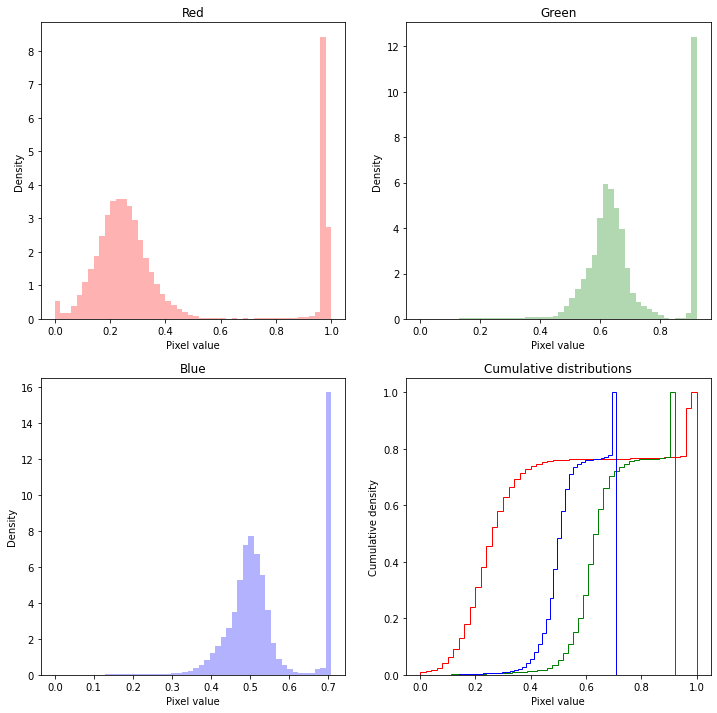

In [22]:
fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(inverted_retina_image, cmap=plt.get_cmap('gray'))
plot_image_distributions(inverted_retina_image)

> Next, apply your function to the adaptive histogram equalized gray-scale retina image and display the image along with the distribution plot. 

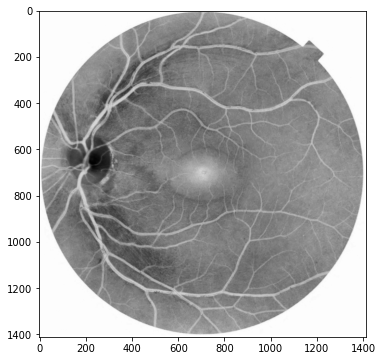

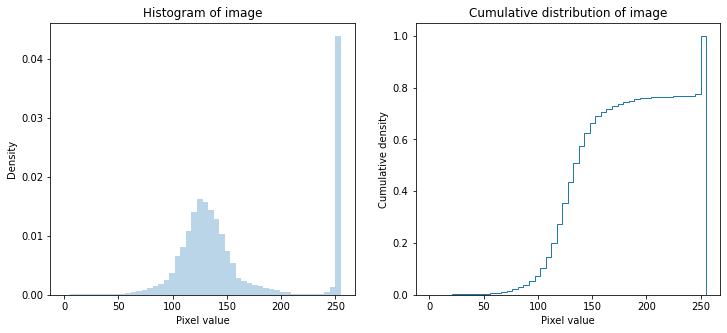

In [23]:
inverted_grayscale=gray_scale_retina_dic['exposure.equalize_adapthist'].copy()
inverted_grayscale=invert_image(inverted_grayscale)
fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(inverted_grayscale, cmap=plt.get_cmap('gray'))
plot_gray_scale_distribution(inverted_grayscale)

> Answer the following questions:   
> 1. Compare the distribution of the pixel values for the three color channels of the inverted image with the distributions for the original image. Do the distributions for the inverted image make sense given the original values and why? 
> 2. Do you think the color of the 3-channel inverted image is correct and why?   
> 3. The difference in pixel value distributions between the inverted gray scale and original adaptive histogram distributions are subtle. What key difference can you identify?     
> **End of exercise.**

> **Answers:**
> 1.    The location of the peaks in the pixel value histogram plot switched in all the channels, including the 0 values which are now 1. For example a peak was 0.2 (out of 1), it would be 0.8 in the inversion. The results for the inverted pixel value histograms (PVH) make sense compared to the PVH of the original image.
> 2.   For the reasons outlined in question 1, the PVH suggests the inversion was performed correctly. An additional tell is that the 0 values in the PVH of the original image are now 1s!
> 3. There are two tells. The first is that the peaks at 0 are now 1's; the place spaces are now white. The second tell is the shape of the gaussian, which is a little hard to tell. In the original image it forms a shape that resembles a small tidal wave facing away from 0. The inversion's shape switched directions.

#### End of 1-7
----

## Sampling and resizing images      

For many computer vision processes the dimensions of an image must be transformed. We have already explored removing the multi-channel color dimension from an image to form the gray-scale image. Now, we will investigate transformation the pixel row and column dimensions of an image. There are two options:       
1. **Down-sample:** A down sampled image has a reduced number of pixels. If the multiple between the pixel count of the original image and the down-sampled image an even number, sampled pixel values are used. Otherwise, interpolation is required for arbitrary multiples. Inevitably, down-sampling will reduce the resolution of the image, and fine details will be lost.                    
2. **Up-sample:** The number of samples can be increased by interpolation between the pixel values. The interpolated values fill in the values of the new pixel. If the pixel count of the up-sampled image is not an even multiple of the original image most of the values will be interpolated. While up-sampling can increase the number number of the pixels, this process cannot increase the resolution of an image.      

> **Exercise 1-8:** You will now resize the adaptive histogram equalized gray-scale image. Using the [skimage.transform.resize](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) function, do the following:      
> 1. Down-sample the image to dimension $(64,64)$. Print the dimensions and display the resulting image.      
> 2. Up-sample the down-sampled image to dimension $(1024,1024)$. Print the dimensions and display the resulting image.

Downsampled dimensions: (64, 64)


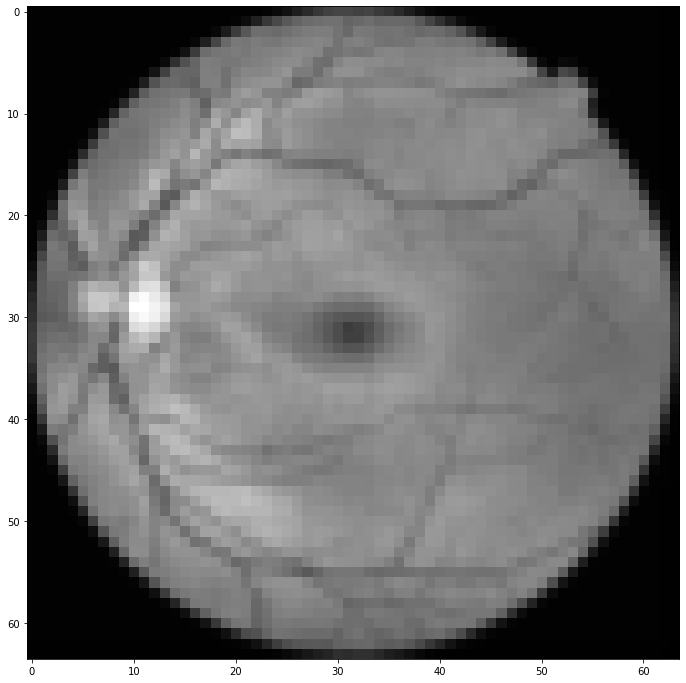

In [24]:
## down sample the image
## Put you code below
downsampled=skimage.transform.resize(gray_scale_retina_dic['exposure.equalize_adapthist'],(64,64))
print("Downsampled dimensions: {}".format(downsampled.shape))
fig, ax = plt.subplots( figsize=(12, 12))
_=ax.imshow(downsampled, cmap=plt.get_cmap('gray'))

Upsampled dimensions: (64, 64)


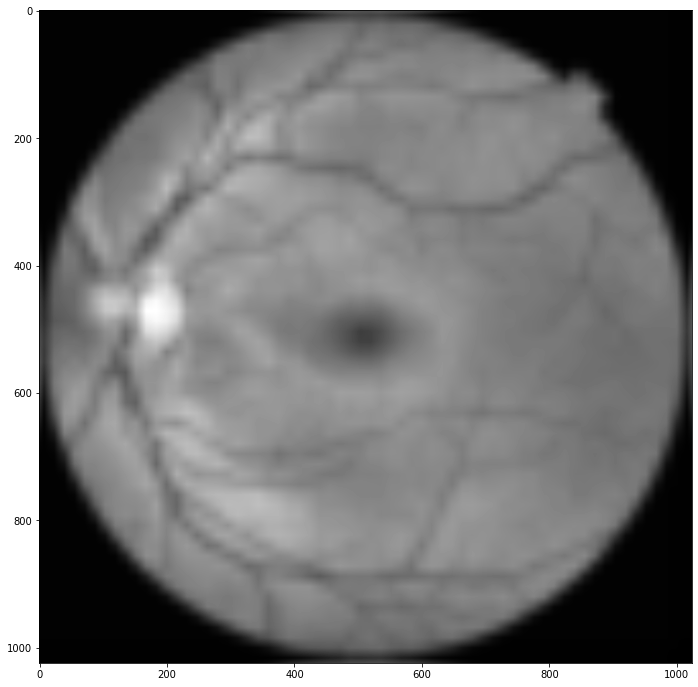

In [25]:
## Up-sample the image
## Put you code below
upsampled=skimage.transform.resize(downsampled,(1024,1024))
print("Upsampled dimensions: {}".format(downsampled.shape))
fig, ax = plt.subplots( figsize=(12, 12))
_=ax.imshow(upsampled, cmap=plt.get_cmap('gray'))

> Notice the changes in resolution of the down-sampled and up-sampled images.  
> 1. How is the reduction in resolution of the $(64,64)$ image exhibited? 
> 2. Does up-sampling to $(1024,1024)$ restore the resolution of the image or simple blur the 'pixelation' visible in the $(64,64)$ image? 
> **End of exercise.**

> **Answers:**
> 1.  Details of the image gets lost and aliasing starts occuring because the granularity is lost.  
> 2. Absolutely not! The image suffers from the previous lack of detail. By downsampling the image, we lose a tremendous amount of information (going from 1411x1441 to 64x64). This loss of information is not restored when we upsample the image.

In [26]:
gray_scale_retina_dic['exposure.equalize_adapthist'].shape

(1411, 1411)

#### End of 1-8
----

## Sampling and Aliasing in Images     

As should be clear from the foregoing, the digital images we work with for computer vision are discretely sampled in the 2-dimensional plane. The discrete pixel values are $v_{\mathbf{x}}$ are the result of this sampling. This discrete sampling limits the **spatial resolution** which can be captured in the image. If the samples are spaced too far apart, [aliasing](https://en.wikipedia.org/wiki/Aliasing) will occur. For sinusoidal components of the image the [Nyquist Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) the sampling frequency must be at least 2 time the frequency of this component. The sampling rate of 2 times the highest frequency component is known as the **Nyquist Frequency**. Sampling below the Nyquist frequency leads to aliasing.            

We can demonstrate the concept of aliasing with a simple example. The example is based on an initial image and three down-sampled versions:    
1. The initial image has diagonal slashes with sinusoidal amplitudes and dimension $(256,256)$.  
2. The image is down-sampled to dimension $(256, 256)$. 
3. The image is down-sampled to dimension $(128, 128)$. 
2. The image is down-sampled to dimension $(64, 64)$. 

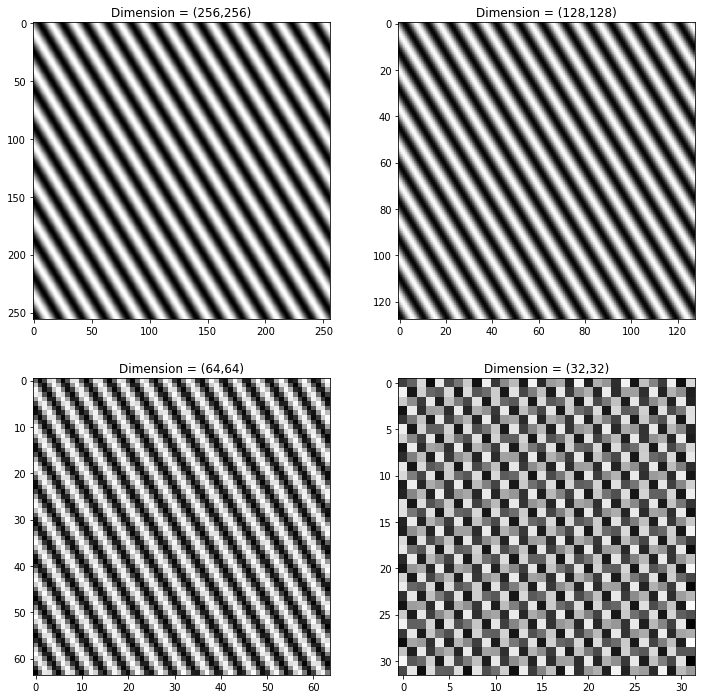

In [27]:
dim = 256
x = np.arange(0, dim*dim, 1)
sin_image = 1.0 - 0.5 * np.sin(np.divide(x, math.pi)).reshape((dim,dim))

fig, ax = plt.subplots(2,2, figsize=(12, 12))
ax = ax.flatten()
for i,dim in enumerate([256,128,64,32]):
    sampled_image = resize(sin_image, (dim,dim))
    _=ax[i].imshow(sampled_image, cmap=plt.get_cmap('gray'))
    _=ax[i].set_title('Dimension = (' + str(dim) + ',' + str(dim) + ')')

Examine the images above and notice the following:  
1. The $(128, 128)$ down-sampled image retains the characteristics of the initial image. Look carefully, you can see a slight blurring.      
2. The $(64, 64)$ down-sampled image retains the sinusoidal slash structure. Coarse pixelation is now quite evident and the sampling is very close to the Nyquist frequency.     
3. The $(32, 32)$ down-sampled image does not resemble the initial image at all, exhibiting significant aliasing. Run your eye side to side and up and down on the image. You may see patterns that are not representative of the original image. Such false patterns are a common artifact arising from aliasing. 

How can aliasing be prevented? A filter can remove the high frequency components of the image which would lead to the aliasing. A common approach is to use a Gaussian filter. This filter removes high frequency components and has the effect of blurring the image.          

> **Exercise 1-9:** You will now investigate how filtering can be applied to prevent aliasing. The [skimage.transform.resize](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) function applies a Gaussian filter to prevent aliasing by default. The standard devision of the Gaussian filter, or filter span, can be set to adjust the bandwidth of the filter.    
> In this exercise you will resample the adaptive histogram equalized gray-scale retina image using the skimage.transform.resize function with the `anti_aliasing=False` argument. You will use the [skimage.filters.gaussian](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.gaussian) to limit the bandwidth of the image. Do the following to compare the results of different filter bandwidths:   
> 1. Computer a scale factor, $sf = \sqrt{\frac{original\ dimension}{reduced\ dimension}}$.
> 2. Apply the Gaussian filter with $sigma = mutltiplier * sf$ for multiplier in the range 0 to 4 and resize the image to $(64,64)$ pixels.
> 3. For each value of sigma display the image with a title indicating the value of sigma. You may find interpretation easier if you plot the images on a $3 \times 2$ grid.

Scale factor: 4.695


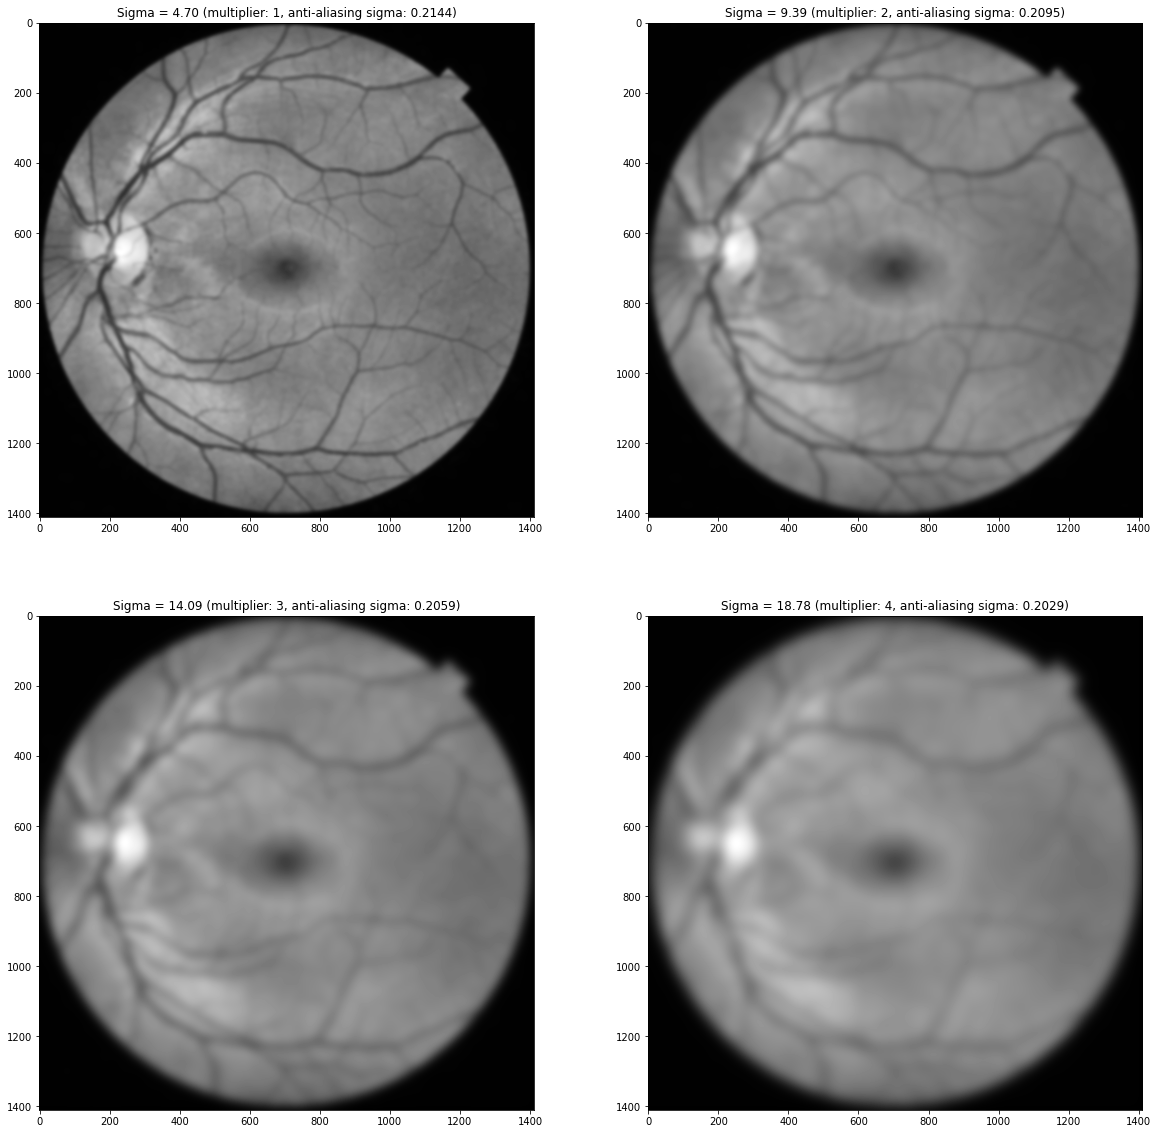

In [28]:
## Put you code below
fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax = ax.flatten()

# Image being used
grayscale_equalhist_retina = gray_scale_retina_dic['exposure.equalize_adapthist'].copy()

# Compute Scale-Factor 
scale_factor=np.sqrt(grayscale_equalhist_retina.shape[0]/64)
print("Scale factor: {:.3f}".format(scale_factor))
# Define Range and downsample the image
multiplier_range=[1,2,3,4]

for i,multiplier in enumerate(multiplier_range):
    # Compute Sigma, get filter
    sigma=multiplier*scale_factor
    filtered_image = skimage.filters.gaussian(grayscale_equalhist_retina, sigma=sigma)
    
    # Downsample
    downsampled=skimage.transform.resize(grayscale_equalhist_retina,
                                         (64,64),
                                         anti_aliasing=False, 
                                         anti_aliasing_sigma=np.std(filtered_image))
    _=ax[i].imshow(filtered_image, cmap=plt.get_cmap('gray'))
    _=ax[i].set_title('Sigma = {:.2f} (multiplier: {}, anti-aliasing sigma: {:.4f})'.format(sigma,
                                                                                        multiplier,
                                                                                        np.std(filtered_image)))

> Answer the following questions.   
> 1. How does the aliasing change with increasing sigma, decreasing bandwidth? Is this the behavior you expect and why?  
> 2. How does the blurring of the image change with increasing sigma, decreasing bandwidth? Is this the behavior you expect and why?
> **End of exercise.**

> **Answers:**   
> 1. Gaussian Kernals is a useful filter for smoothing downsampled images. As the span gets smaller (sigma gets larger), aliasing decreases at the cost of blurriness.   
> 2. As the span gets smapper (larger sigma), bandwidth gets smaller and the blurring becomes more extreme. In order to remove noise, guassian filters smoothens/softens out high-frequency details. This becomes a problem as spans gets smaller because the gaussian filter is softening up more and more details as the span (essentially the window where the filtering is computed) gets smaller. By having a larger span we prevent overapplying the filter. 

#### Copyright 2021, Stephen F Elston. All rights reserved. 